# ВНИМАНИЕ!

Следующее задание крайне рекомендуется выполнять в Google Colab, чтобы обеспечить отсутствие проблем с соединением при скачивании датасета, а также чтобы обеспечить скорость при обучении нейросети. 

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import glob

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format ='retina'

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

# Transfer learning

На этом семинаре мы научимся очень быстро обучать нейросеть на сложную задачу классификации изображений, используя очень простой приём, именуемый fine tuning'ом. 

Для начала скачем датасет. На этот раз мы научим нейронку отличать кошечек от собачек.

In [2]:
! wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip && unzip kagglecatsanddogs_3367a.zip > /dev/null

--2020-10-25 21:03:05--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.248.137, 2600:1409:12:285::e59, 2600:1409:12:2af::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.36.248.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M  92.6MB/s    in 9.8s    

2020-10-25 21:03:15 (80.5 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



Удалим несколько битых изображений

In [3]:
! rm -rf ./PetImages/Cat/666.jpg ./PetImages/Dog/11702.jpg

Датасет разделим средствами pytorch'a на трейн и тест.

In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose

# Загружаем картинки из папки в датасет
dataset = ImageFolder("./PetImages", transform=Compose([Resize((224, 224)), ToTensor(), Normalize((0.5, 0.5, 0.5), (1, 1, 1)), ]))
# Делим выборку на обучающую и тестовую
train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

Сделаем из скачанных датасетов даталоадеры

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)

Посмотрим, как выглядят картинки.

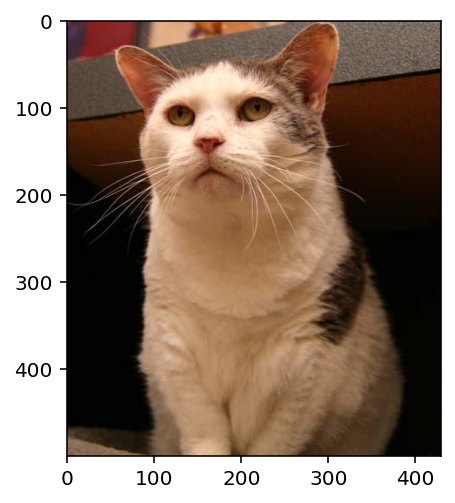

In [6]:

file = np.random.choice(glob.glob("./PetImages/*/*.jpg"))
plt.imshow(plt.imread(file))

## Fine-Tuning

Кошки и собаки — это, конечно, хорошо, вот только обучение модели, которая будет хорошо работать на этом датасете может оказаться очень долгим...

Однако картинки, которые мы сегодня рассмотрим оказываются очень похожими на картинки из огромного датасета ImageNet. Задача, которую мы сегодня рассмотрим, называется Transfer Learning — в русскоязычной литературе иногда можно встретить термин "обучение с переносом знаний". Знания мы действительно переносим — от сети, которая хорошо работает на одном датасете (ImageNet) к другим данным (к датасету Cats vs Dogs).

### Загрузим уже обученную сеть

В библиотеке `torchvision` имплементировано не только большое множество моделей (всевозможные ResNet'ы, Inception, VGG, AlexNet, DenseNet, ResNext, WideResNet, MobileNet...), но и загружены чекпоинты обучения этих моделей на ImageNet. Однако для датасета Cats vs Dogs такая штука является роскошью...

In [7]:
from torchvision.models import resnet18

# Загрузить предобученную сеть: pretrained=True
model = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
for param in model.parameters():
    param.requires_grad = False

В задаче transfer learning'a мы заменяем последний слой нейросети на линейный с двумя выходами.

In [10]:
model.fc = nn.Linear(512, 2)

Ниже несколько функций, которые мы уже видели в предыдущих семинарах.

In [11]:
def train_epoch(model, data_loader, optimizer, 
                criterion, return_losses=False, device='cuda:0'):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device='cuda:0'):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

In [12]:
def fit(model, epochs, train_data_loader, validation_data_loader,
        optimizer, criterion):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics['loss'])

Создайте объект лосса и оптимизатор.

In [13]:
criterion = nn.CrossEntropyLoss()
# Явно укажем слой, для которого мы хотим провести оптимизацию 
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)

In [14]:
fit(model, 10, train_dataloader, test_dataloader, optimizer, criterion)

Train Epoch: 0
Loss: 0.5437 Accuracy: 79.2969:  44%|████▍     | 35/79 [00:57<01:12,  1.64s/it]

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Loss: 0.4182 Accuracy: 86.6667: 100%|██████████| 79/79 [02:06<00:00,  1.60s/it]
Validation Epoch: 0
Loss: 0.4078 Accuracy: 91.1765: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]
Train Epoch: 1
Loss: 0.3007 Accuracy: 93.3333: 100%|██████████| 79/79 [02:02<00:00,  1.55s/it]
Validation Epoch: 1
Loss: 0.2675 Accuracy: 95.5882: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
Train Epoch: 2
Loss: 0.1879 Accuracy: 96.6667: 100%|██████████| 79/79 [01:58<00:00,  1.50s/it]
Validation Epoch: 2
Loss: 0.2095 Accuracy: 94.1176: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
Train Epoch: 3
Loss: 0.1779 Accuracy: 96.6667: 100%|██████████| 79/79 [01:57<00:00,  1.49s/it]
Validation Epoch: 3
Loss: 0.1781 Accuracy: 94.1176: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
Train Epoch: 4
Loss: 0.1294 Accuracy: 96.6667: 100%|██████████| 79/79 [01:59<00:00,  1.51s/it]
Validation Epoch: 4
Loss: 0.1589 Accuracy: 95.5882: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
Train Epoch: 5
Loss: 0.1259 Accuracy: 10

Как видим на одну эпоху обучения уходит порядка двух минут, и уже после одной эпохи получается приемлемое качество. Давайте проинициализируем модель с нуля и попробуем обучить.

In [15]:
model_full = resnet18(pretrained=False)
model_full.fc = nn.Linear(512, 2)
optimizer = torch.optim.Adam(model_full.parameters(), 1e-4) # YOUR CODE. It must optimize across all parameters

In [16]:
fit(model_full, 10, train_dataloader, test_dataloader, optimizer, criterion)

Train Epoch: 0
Loss: 0.7555 Accuracy: 55.8594:  54%|█████▍    | 43/79 [01:27<01:13,  2.05s/it]

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Loss: 0.7318 Accuracy: 60.0: 100%|██████████| 79/79 [02:39<00:00,  2.01s/it]
Validation Epoch: 0
Loss: 0.7902 Accuracy: 50.7353: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
Train Epoch: 1
Loss: 0.9532 Accuracy: 33.3333: 100%|██████████| 79/79 [02:38<00:00,  2.01s/it]
Validation Epoch: 1
Loss: 0.8469 Accuracy: 49.2647: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
Train Epoch: 2
Loss: 0.8199 Accuracy: 50.0: 100%|██████████| 79/79 [02:38<00:00,  2.01s/it]
Validation Epoch: 2
Loss: 0.7799 Accuracy: 54.4118: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
Train Epoch: 3
Loss: 0.8137 Accuracy: 50.0: 100%|██████████| 79/79 [02:38<00:00,  2.00s/it]
Validation Epoch: 3
Loss: 0.824 Accuracy: 48.5294: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
Train Epoch: 4
Loss: 0.8059 Accuracy: 53.3333: 100%|██████████| 79/79 [02:38<00:00,  2.01s/it]
Validation Epoch: 4
Loss: 0.7457 Accuracy: 55.8824: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]
Train Epoch: 5
Loss: 0.8598 Accuracy: 46.6667: 100

Как мы видим, на transfer learning'e нейросеть сходится очень быстро. Значительно быстрее, чем инициализированная с нуля. Можно с уверенностью говорить, что transfer learning — очень полезная техника.

## Adversarial атаки.

Такая вещь, как атаки на нейросеть крайне важны для учёта при разработке. Существует много методов как их генерации, так и защиты от них. Мы рассмотрим сегодня базовые концепты, чтобы дать понимание происходящего.

Можем назвать adversarial атакой генерацию такого примера, который не отличим глазом от настоящего, но нейросеть будет ОЧЕНЬ уверена в том, что этот пример из другого класса. Сейчас мы попробуем сгенерировать такую собачку, что нейросеть будет уверена, что это котик.

<img src="https://pytorch.org/tutorials/_images/fgsm_panda_image.png">

Сегодня мы рассмотрим пример Fast Gradient Sign Attack (FGSM, почему там буква M в конце — чёрт его знает...). Идея очень простая. Оказывается, что если мы через обученную нейросеть посчитаем градиент по исходной картинке, посчитаем  его знак и прибавим, умножив на маленькое число, модель подумает, что это картиинка другого класса.

Для того, чтобы нам посчитать градиент по входу, нам предстоит "разморозить" все её граиенты.

In [17]:
model.eval()

for param in model.parameters():
    param.requires_grad = True

In [18]:
def fgsm_attack(image, epsilon, data_grad):
    # То есть идем по росту ошибки, а не убыванию
    pertrubated_image = image + epsilon * torch.sign(data_grad)
    return pertrubated_image

Выбираем из датасета случайную картинку с кошечкой

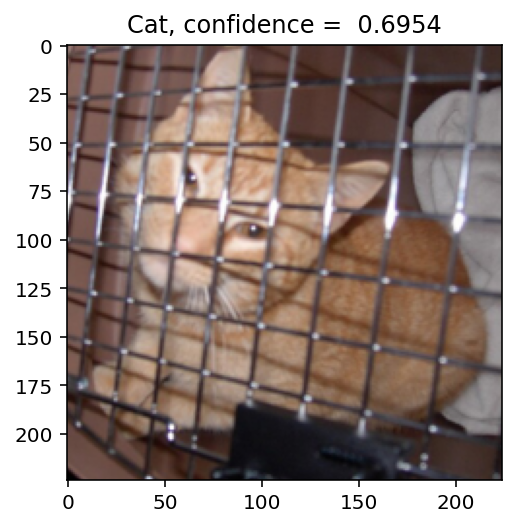

In [19]:
cl = 1
while cl == 1:
    i = np.random.randint(0, len(train_set))
    cl = train_set[i][1]
    image = train_set[i][0]
    image = image.to('cuda:0')
    # Разрешим вычисление градиента по картинке
    image.requires_grad = True
    
    pred = model(image[None])
    predicted_label = pred.argmax(1).item()
    confidence = pred.softmax(1)[0][predicted_label]


# красиво рисуем
if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence =  %0.4f" % confidence.item())
plt.imshow(image.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5);

Самое интересное начинается тут. Вычислим градиент функции потерь по картинке при помощи вызова .backward().

In [20]:
loss = criterion(pred, torch.tensor(cl).reshape((1,)).to("cuda:0"))
loss.backward()

Произведём атаку.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


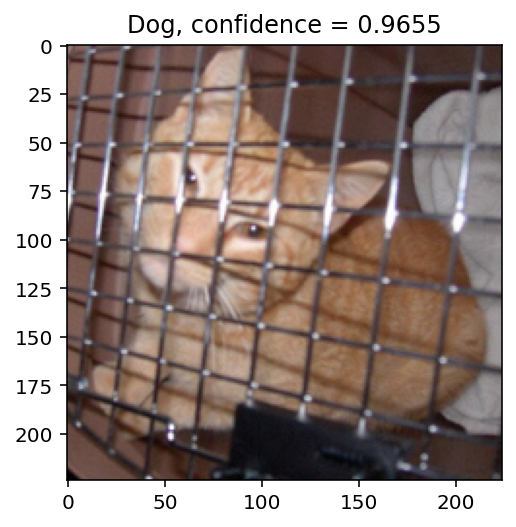

In [21]:
eps = 0.007

attack = fgsm_attack(image, eps, image.grad)
pred = model(attack[None])
predicted_label = pred.argmax(1).item()
confidence = pred.softmax(1)[0][predicted_label]

if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence =  %0.4f" % confidence.item())
plt.imshow(attack.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5)